In [2]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [529]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

import seaborn as sn  # for heatmaps

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [357]:
# Acquire data for model
train_df = pd.read_csv('../KaggleData/train_data.csv', header=None, dtype="float64")
train_target_df = pd.read_csv('../KaggleData/train_target.csv', header=None, dtype="int32")

valid_df = pd.read_csv('../KaggleData/test_data.csv', header=None, dtype="float64")

In [358]:
# Split the data for testing the model
train_size = int(len(train_df))

train_split_df = train_df[:train_size-int(train_size*.2)]
train_target_split_df = train_target_df[:train_size-int(train_size*.2)]

test_df = train_df[train_size-int(train_size*.2):len(train_df)]
test_target_df = train_target_df[train_size-int(train_size*.2):len(train_df)]



In [445]:
# Convert the Dataframse to numpy Arrays
train_split_arr = train_split_df.to_numpy()
train_target_split_arr = train_target_split_df.to_numpy()

test_arr = test_df.to_numpy()
test_target_arr = test_target_df.to_numpy()

submit_arr = valid_df.to_numpy()

In [504]:
# Convert NumPy Arrays to tensors by creating a Feature Dataset class
# We will use StandardScaler from sklearn
# Code from https://shashikachamod4u.medium.com/excel-csv-to-pytorch-dataset-def496b6bcc1
class FeatureDataset(Dataset):
    def __init__(self, data_arr, target_arr, transform=None):
        self.data = data_arr
        self.target = torch.tensor(target_arr, dtype=torch.int64)
        self.transform = transform
        
        # Necessary for normalization
        self.mean = data_arr.mean()
        self.std = data_arr.std()
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        image = torch.from_numpy(self.data[idx].reshape(-1,48,48)) # Reshape the tensor to have 4 dimensions    
        image = ((image - self.mean) / self.std) *.5 # Normalize the data   
        self.target = self.target.view(-1)
        
        # Apply transmissions if needed
        if self.transform is not None: 
            image = self.transform(image)
            
        return image.type(torch.FloatTensor), self.target[idx]

In [505]:
# Acquire the set
display_dataset = FeatureDataset(train_arr, train_target_arr)
train_set = FeatureDataset(train_arr, train_target_arr, 
                           transform=transforms.Compose([
                               transforms.RandomRotation(30),
                               transforms.RandomHorizontalFlip(p=.7),
#                                transforms.Resize(38),
                               #transforms.CenterCrop(45),
                               transforms.RandomApply([transforms.GaussianBlur(5)], p=.5)
                           ]))
# test_set = FeatureDataset(test_df, test_target_df)
test_set = FeatureDataset(test_arr, test_target_arr)

In [506]:
# Acquire the loaders from the set
display_loader = DataLoader(display_dataset, batch_size=10, shuffle=True)
train_loader = DataLoader(train_set, batch_size=20, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10000, shuffle=False)

In [507]:
for x, y in display_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


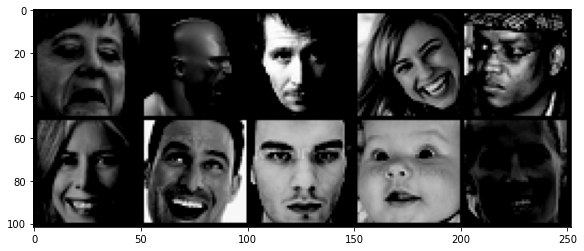

In [509]:
# Check to see if loader works
im = make_grid(x, nrow=5)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [454]:
##### Build model

class FacialRecognitionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=64)
        self.conv1_dropout = nn.Dropout2d(p=.4)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=128)
        self.conv2_dropout = nn.Dropout2d(p=.4)
        
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_batchnorm = nn.BatchNorm2d(num_features=256)
        self.conv3_dropout = nn.Dropout2d(p=.4)
        
        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_batchnorm = nn.BatchNorm2d(num_features=512)
        self.conv4_dropout = nn.Dropout2d(p=.4)
        
        # FC Layer 1
        self.fc1 = nn.Linear(512*3*3, 256)
        self.fc1_batchnorm = nn.BatchNorm1d(num_features=256)
        self.fc1_dropout = nn.Dropout(p=.4)
        
        # Fc layer 2
        self.fc2 = nn.Linear(256, 512)
        self.fc2_batchnorm = nn.BatchNorm1d(num_features=512)
        self.fc2_dropout = nn.Dropout(p=.4)
        
        self.out = nn.Linear(512, 3)
        
    def forward(self, X):
        # Run the the CNs
        X = self.conv1_dropout(F.max_pool2d(F.relu(self.conv1_batchnorm(self.conv1(X))), 2,2))
        X = self.conv2_dropout(F.max_pool2d(F.relu(self.conv2_batchnorm(self.conv2(X))), 2,2))
        X = self.conv3_dropout(F.max_pool2d(F.relu(self.conv3_batchnorm(self.conv3(X))), 2,2))
        X = self.conv4_dropout(F.max_pool2d(F.relu(self.conv4_batchnorm(self.conv4(X))), 2,2))
        
        # Flatten the dimensions
        X = X.view(-1,3*3*512)
        
        # RUn the FCs
        X = self.fc1_dropout(F.relu(self.fc1_batchnorm(self.fc1(X))))
        X = self.fc2_dropout(F.relu(self.fc2_batchnorm(self.fc2(X))))
        
        X = self.out(X)
        
        return F.log_softmax(X, dim=1) # Send output through a softmax filter
        

In [467]:
# Initialize Training Functions
torch.manual_seed(101) # Seed for randomness

the_model = FacialRecognitionCNN() # Initialize Model
criterion = nn.CrossEntropyLoss() # Initialize Loss function
optimizer = torch.optim.Adam(the_model.parameters(), lr=.001) # Initialize optimizer


In [469]:
epochs = 20

train_losses = []
train_correct = []

for i in range(1,epochs+1):
    trn_corr = 0 # Keep track of accuracy
    
    # Create a new loader for each epoch to distinguish the training data
    train_loader = DataLoader(train_set, batch_size=20, shuffle=True) 
    
    # Batch Training loop
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = the_model(X_train)
        loss = criterion(y_pred, y_train)

        # tally number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if b%200 == 0:
            print(f'Epoch {i} Batch {b} Loss {loss.item()} accuracy: {trn_corr.item()*100/(20*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    

Epoch 1 Batch 200 Loss 1.0950520038604736 accuracy:  42.000%
Epoch 1 Batch 400 Loss 1.2368710041046143 accuracy:  42.237%
Epoch 1 Batch 600 Loss 1.0010477304458618 accuracy:  42.517%
Epoch 1 Batch 800 Loss 1.0446568727493286 accuracy:  42.650%
Epoch 2 Batch 200 Loss 1.089205026626587 accuracy:  45.525%
Epoch 2 Batch 400 Loss 1.0452061891555786 accuracy:  45.263%
Epoch 2 Batch 600 Loss 1.0315505266189575 accuracy:  45.808%
Epoch 2 Batch 800 Loss 1.0042163133621216 accuracy:  46.550%
Epoch 3 Batch 200 Loss 0.9603751301765442 accuracy:  49.600%
Epoch 3 Batch 400 Loss 1.0688785314559937 accuracy:  50.737%
Epoch 3 Batch 600 Loss 1.094801425933838 accuracy:  52.250%
Epoch 3 Batch 800 Loss 0.9775729179382324 accuracy:  52.450%
Epoch 4 Batch 200 Loss 0.9961225390434265 accuracy:  55.475%
Epoch 4 Batch 400 Loss 1.0392128229141235 accuracy:  55.275%
Epoch 4 Batch 600 Loss 1.1771442890167236 accuracy:  55.575%
Epoch 4 Batch 800 Loss 1.0148802995681763 accuracy:  56.163%
Epoch 5 Batch 200 Loss 0.6

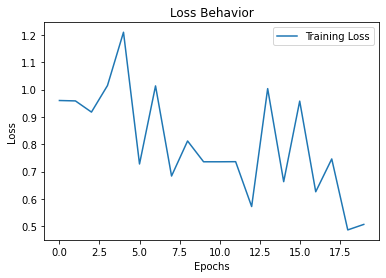

In [510]:
with torch.no_grad():
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Behavior")
    plt.legend()

In [517]:
# Test Model
correct = 0
idx = 2000
the_model.eval()
with torch.no_grad():
    for test_data, test_target in test_loader:
        y_val = the_model(test_data)
        predicted = torch.max(y_val.data, 1)[1]
        print(len(y_val), len(test_target), len(predicted))
        correct += (predicted == test_target).sum()

print(f'Testing the model got {correct} correct, with {100*correct / len(test_target):.2f}% correct')

3235 3235 3235
Testing the model got 2538 correct, with 78.45% correct


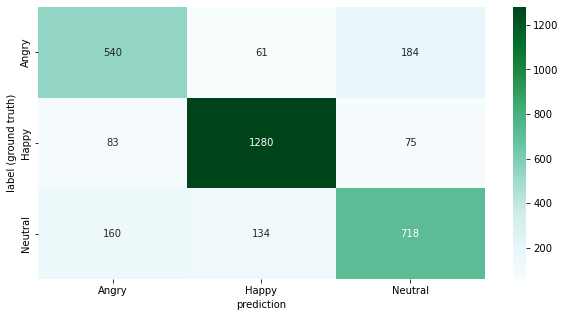

In [525]:
# Confusion Matrix
arr = confusion_matrix(test_target.view(-1), predicted.view(-1))
class_names = ['Angry', 'Happy', 'Neutral']

df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (10,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [516]:
# Prep the submitted data

submit_data = FeatureDataset(submit_arr, np.arange(len(submit_arr)))
submit_loader = DataLoader(submit_data, batch_size=10000, shuffle=False)

headerList= ["Category"]

# Run the model on test data and send to csv
with torch.no_grad():
    for sub_data, sub_target in submit_loader:
        y_val = the_model(sub_data)
        predicted = torch.max(y_val, 1)[1]
        predicted_df = pd.DataFrame(predicted.numpy())
        predicted_df.to_csv('../KaggleData/predicted_test_3.csv', header=headerList, index_label='Id')

In [530]:
# Save Model
torch.save(the_model.state_dict(), 'FacialExpressionClassificationModel.pt')

AttributeError: module 'torch' has no attribute '_utils'